# Loan Default classification prediction

## 1 Import package

In [1]:
import pandas as pd
import sqlite3
import time
import joblib
import warnings
from units import *
import seaborn as sns; sns.set_theme()
warnings.filterwarnings('ignore')

Extra modules need to install: 


pip install xgboost/shap/seaborn

## 1 Import the analysis data set

In [3]:
conn=sqlite3.connect('./loan_application_data.db')
c=conn.cursor()
c.execute("select * from loan_data") 
col_name_list = [tuple[0] for tuple in c.description] 
tabel=c.execute('select * from loan_data')
loan_data=pd.DataFrame(tabel,columns=col_name_list)
loan_data

,ID,business_or_commercial,loan_amount,rate_of_interest,term,interest_only,property_value,income,credit_score,age,ltv,dtir1,status
0,24890,1,116500.0,3.5833333333333335,360,1,118000.0,1740.0,758,0,98.72881356,45.0,1
1,24891,1,406500.0,4.56,360,1,508000.0,9480.0,834,1,80.01968504,46.0,0
2,24892,1,456500.0,4.25,360,1,658000.0,11880.0,587,2,69.3768997,42.0,0
3,24893,1,696500.0,4.0,360,1,758000.0,10440.0,602,0,91.88654354,39.0,0
4,24894,1,706500.0,3.99,360,1,1008000.0,10080.0,864,1,70.08928571,40.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133565,158455,1,436500.0,3.125,180,1,608000.0,7860.0,659,3,71.79276316,48.0,0
133566,158456,1,586500.0,5.19,360,1,788000.0,7140.0,569,0,74.42893401,15.0,0
133567,158457,1,446500.0,3.125,180,1,728000.0,6900.0,702,2,61.33241758,49.0,0
133568,158458,1,196500.0,3.5,180,1,278000.0,7140.0,737,3,70.68345324,29.0,0


In [4]:

rawdata=loan_data[loan_data.columns[1:]]

## 2 Data cleaning

### 2.1 feature select

In [5]:
rawdata.columns

Index(['business_or_commercial', 'loan_amount', 'rate_of_interest', 'term',
       'interest_only', 'property_value', 'income', 'credit_score', 'age',
       'ltv', 'dtir1', 'status'],
      dtype='object')

In [6]:
dtypes=[int,float,float,float,int,float,float,float,int,float,float,float,int]
rawdata=rawdata.astype(dict(zip(list(rawdata.columns),dtypes)))

In [7]:

rawdata.head()

,business_or_commercial,loan_amount,rate_of_interest,term,interest_only,property_value,income,credit_score,age,ltv,dtir1,status
0,1,116500.0,3.583333,360.0,1,118000.0,1740.0,758.0,0,98.728814,45.0,1.0
1,1,406500.0,4.560000,360.0,1,508000.0,9480.0,834.0,1,80.019685,46.0,0.0
2,1,456500.0,4.250000,360.0,1,658000.0,11880.0,587.0,2,69.376900,42.0,0.0
3,1,696500.0,4.000000,360.0,1,758000.0,10440.0,602.0,0,91.886544,39.0,0.0
4,1,706500.0,3.990000,360.0,1,1008000.0,10080.0,864.0,1,70.089286,40.0,0.0


### 2.2 under-sampling

In [13]:
rawdata[rawdata['status']==1].rate_of_interest.describe()

count    21543.000000
mean         3.818412
std          0.419441
min          2.750000
25%          3.500000
50%          3.788333
75%          4.083333
max          6.240000
Name: rate_of_interest, dtype: float64

In [11]:
rawdata[rawdata['status']==0].rate_of_interest.describe()

count    112027.000000
mean          4.044937
std           0.561363
min           0.000000
25%           3.625000
50%           3.990000
75%           4.375000
max           8.000000
Name: rate_of_interest, dtype: float64

In [14]:
rawdata.dtypes

business_or_commercial      int32
loan_amount               float64
rate_of_interest          float64
term                      float64
interest_only               int32
property_value            float64
income                    float64
credit_score              float64
age                         int32
ltv                       float64
dtir1                     float64
status                    float64
dtype: object

### 2.3 dataset_split

In [15]:
# set X sample and Y  then get train_test_split with train and test
X=rawdata.iloc[:,:-1]
Y=rawdata.iloc[:,-1:]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [92]:
X

,business_or_commercial,loan_amount,rate_of_interest,term,interest_only,property_value,income,credit_score,age,ltv,dtir1
0,1,116500.0,3.583333,360,1,118000.0,1740.0,758,0,98.728814,45.0
1,1,406500.0,4.560000,360,1,508000.0,9480.0,834,1,80.019685,46.0
2,1,456500.0,4.250000,360,1,658000.0,11880.0,587,2,69.376900,42.0
3,1,696500.0,4.000000,360,1,758000.0,10440.0,602,0,91.886544,39.0
4,1,706500.0,3.990000,360,1,1008000.0,10080.0,864,1,70.089286,40.0
...,...,...,...,...,...,...,...,...,...,...,...
133565,1,436500.0,3.125000,180,1,608000.0,7860.0,659,3,71.792763,48.0
133566,1,586500.0,5.190000,360,1,788000.0,7140.0,569,0,74.428934,15.0
133567,1,446500.0,3.125000,180,1,728000.0,6900.0,702,2,61.332418,49.0
133568,1,196500.0,3.500000,180,1,278000.0,7140.0,737,3,70.683453,29.0


### 2.4 normalized

In [16]:
# Import the standardized function library
sc = StandardScaler()
# Use of adaptive standardization of training features
X_train_std = sc.fit_transform(X_train)
# Use common standardization for test characteristics
X_test_std = sc.transform(X_test)
dataset=X_train_std, Y_train, X_test_std, Y_test
joblib.dump(sc,'model/standardized.pkl')

['model/standardized.pkl']

## 3 training model

BaseLine : ExtraTrees


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.88,0.84,0.88,0.86,0.87
recall,0.99,0.30,0.88,0.65,0.88
f1-score,0.93,0.44,0.88,0.69,0.85
support,22372.00,4342.00,0.88,26714.00,26714.00


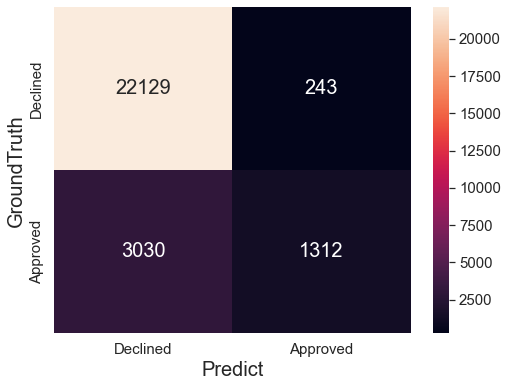

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,ExtraTrees,0.87748,0.84373,0.459019,0.84373,0.879566,0.302165,0.444972,1312,243,22129,3030


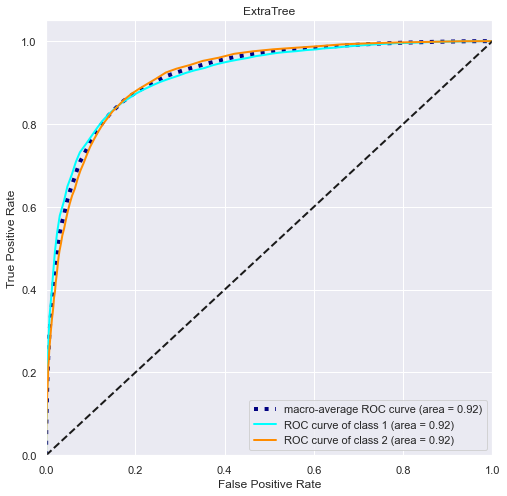

BaseLine : KNeighbors


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.86,0.58,0.85,0.72,0.82
recall,0.97,0.20,0.85,0.58,0.85
f1-score,0.91,0.29,0.85,0.60,0.81
support,22372.00,4342.00,0.85,26714.00,26714.00


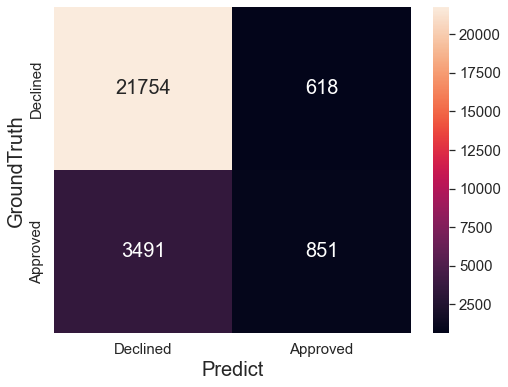

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,KNeighbors,0.846186,0.579306,0.272496,0.579306,0.861715,0.195993,0.292893,851,618,21754,3491


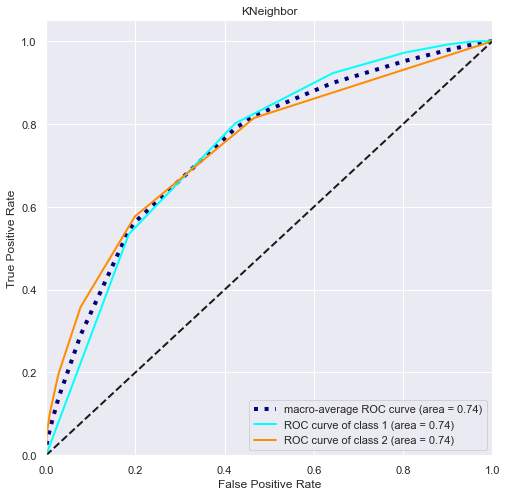

BaseLine : XGBoost


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.97,0.98,0.98,0.98,0.98
recall,1.00,0.86,0.98,0.93,0.98
f1-score,0.99,0.92,0.98,0.95,0.98
support,22372.00,4342.00,0.98,26714.00,26714.00


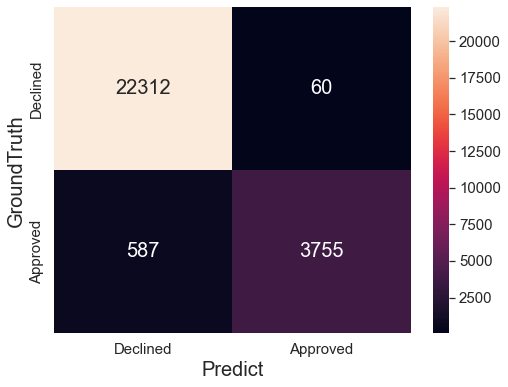

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,XGBoost,0.97578,0.984273,0.909103,0.984273,0.974366,0.864809,0.920682,3755,60,22312,587


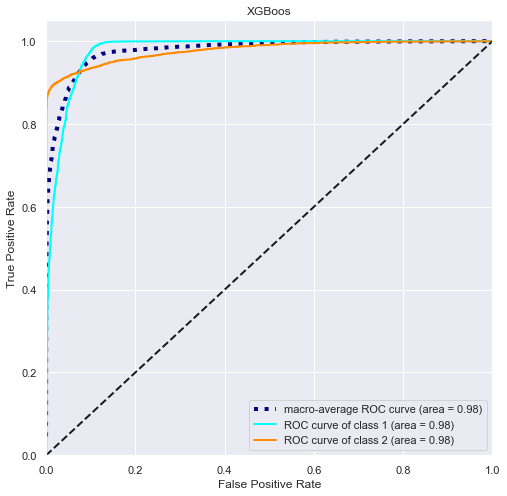

BaseLine : DecisionTree


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.97,0.83,0.95,0.90,0.95
recall,0.96,0.85,0.95,0.91,0.95
f1-score,0.97,0.84,0.95,0.90,0.95
support,22372.00,4342.00,0.95,26714.00,26714.00


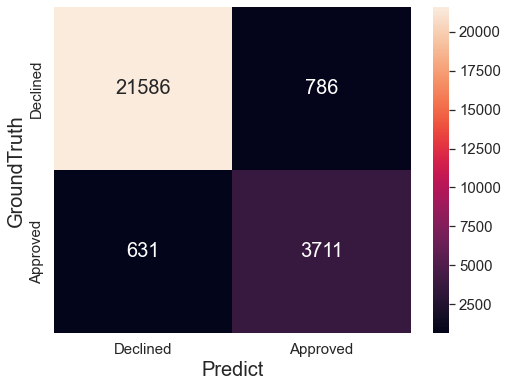

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,DecisionTree,0.946957,0.825217,0.808099,0.825217,0.971598,0.854675,0.839688,3711,786,21586,631


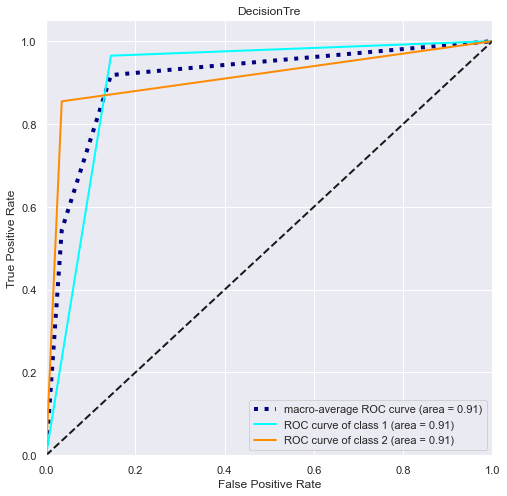

BaseLine : RandomForest


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.93,0.91,0.93,0.92,0.93
recall,0.99,0.62,0.93,0.80,0.93
f1-score,0.96,0.74,0.93,0.85,0.92
support,22372.00,4342.00,0.93,26714.00,26714.00


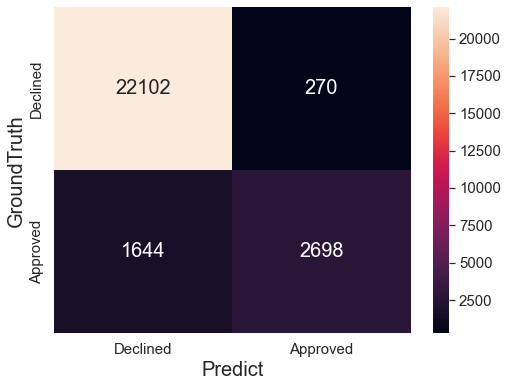

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,RandomForest,0.928352,0.90903,0.715326,0.90903,0.930767,0.621373,0.738167,2698,270,22102,1644


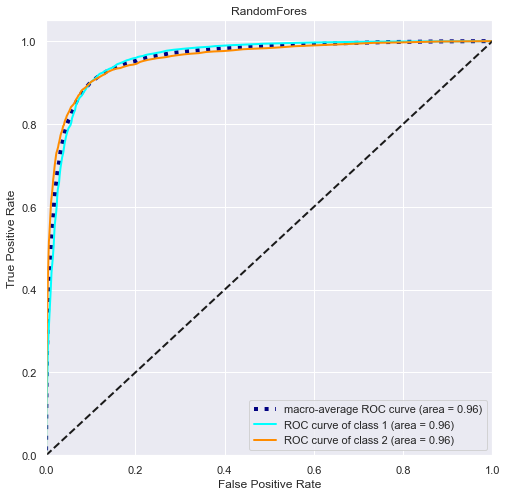

BaseLine : GradientBoosting


,Declined,Approved,accuracy,macro avg,weighted avg
precision,0.94,0.97,0.94,0.96,0.95
recall,1.00,0.67,0.94,0.83,0.94
f1-score,0.97,0.80,0.94,0.88,0.94
support,22372.00,4342.00,0.94,26714.00,26714.00


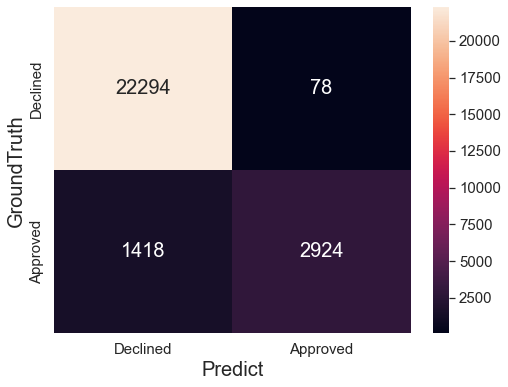

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,GradientBoosting,0.943999,0.974017,0.782602,0.974017,0.940199,0.673422,0.796296,2924,78,22294,1418


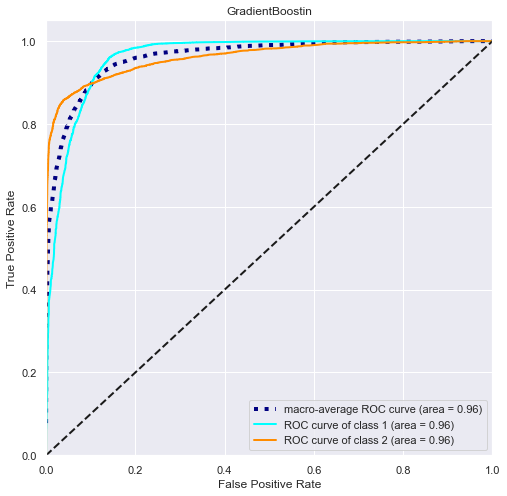

In [17]:
methods=['ExtraTrees', 'KNeighbors', 'XGBoost', 'DecisionTree', 'RandomForest','GradientBoosting'] # define the model and evaluate
method_compare=[]#compare the score and save 
label_column=['Declined','Approved'] # mark the approved and decliend sample
model_list=[] # save the trained model
for method in methods:
    #define the path and save to ./save/methods directory
    path='save/'+method+'/'
    if not os.path.isdir(path):
        os.makedirs(path)
    print('='*100) # divide the area 
    print('BaseLine : '+method)
    # evaluate get the method, dataset and return results for evaluation
    groundtruth, predict, predictprob,item,model=evaluate(method,dataset)
    model_list.append(model)
    method_compare.append(item)
    # create the confusion matrix
    matrix=metrics.confusion_matrix(groundtruth, predict)
    # create the prediction report
    report=classification_report(groundtruth, predict,target_names=label_column,output_dict=True)
    # save the report with two decimal
    report=round(pd.DataFrame(report).T,2)
    # save the result report
    report.T.to_csv(path+'report.csv',encoding='utf_8')
    display(report.T)
    # plot confusion matrix
    plot_matrix(groundtruth, predict,path+'./confusion_matrix.png')
    display(pd.DataFrame([method_compare[-1]]))
     # plot roc
    ROC_plot(Y_test,predictprob,path+method)
    # save the model
    joblib.dump(model,'./model/'+method+'.sav')

<BarContainer object of 11 artists>

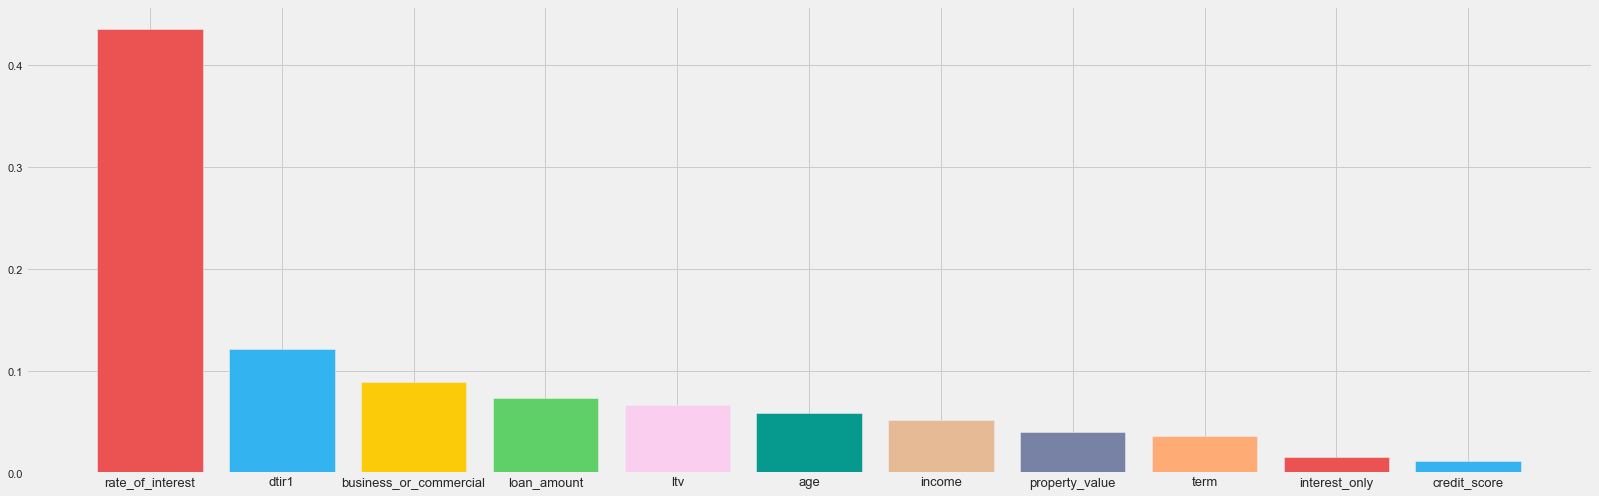

In [27]:
plt.style.reload_library()
plt.style.use('fivethirtyeight')
importances=dict(zip(X.columns,model_list[2].feature_importances_))
importances=[(value, key) for key, value in importances.items()]
importances_sorted = sorted(importances,reverse=True)
plt.figure(figsize=(25,8))
plt.xticks(size=13)
plt.bar([x[1] for x in importances_sorted],[x[0] for x in importances_sorted],color=['#EB5353','#34B3F1','#FBCB0A','#5FD068','#F9CEEE',"#069A8E", "#E6BA95", "#7882A4","#FFAB76"])

### Train XGBoost Model

In [28]:
# Train XGBoost model
from sklearn.model_selection import GridSearchCV
XGmodel = XGBClassifier()
XGmodel.fit(X_train, Y_train)

# make predictions for test data
y_pred = XGmodel.predict(X_test)

predictions = [round(value) for value in y_pred]


#### Select top 8 importance features

In [59]:
feature_df = pd.DataFrame({"feature" : X_train.columns,
    "importance" : XGmodel.feature_importances_    
})
top8 = list(feature_df.sort_values(by=["importance"], ascending=False).head(8)["feature"])
top8

['rate_of_interest',
 'dtir1',
 'business_or_commercial',
 'loan_amount',
 'ltv',
 'age',
 'income',
 'property_value']

In [60]:
X_train_top8 = X_train[top8]
X_test_top8 = X_test[top8]
X_test_top8.head()

,rate_of_interest,dtir1,business_or_commercial,loan_amount,ltv,age,income,property_value
96527,4.625000,37.000000,1,236500.0,79.362416,2,7260.0,298000.0
89750,3.916667,35.000000,1,706500.0,76.131466,4,6540.0,928000.0
121478,2.990000,29.666667,1,426500.0,70.148026,2,8600.0,608000.0
117611,4.250000,49.000000,1,216500.0,90.966387,0,2820.0,238000.0
59979,3.701667,28.000000,1,516500.0,68.139842,3,14700.0,758000.0


In [61]:
# Export the X_test_top8 data to csv for later use
X_test_top8.to_csv('data_XGBoost_TopFeatures.csv')

In [62]:
# The following age list value,label,sequence were derived from LabelEncoder class function, will be used in pairplot legend
age_list = [0,1,2,3,4,5,6]
age_label_list = ['25-34', '35-44', '45-54', '55-64', '65-74', '<25', '>74']
age_df = pd.DataFrame({'age' : age_list, 'age_label' : age_label_list})
age_df

,age,age_label
0,0,25-34
1,1,35-44
2,2,45-54
3,3,55-64
4,4,65-74
5,5,<25
6,6,>74


In [63]:
age_groupby_list = X_test_top8.groupby(['age']).count()
age_groupby_list.reset_index(inplace = True)
age_groupby_cols = ['age', 'ltv']
age_groupby_list_transformed = age_groupby_list[age_groupby_cols].copy()
age_groupby_list_transformed.rename(columns={'ltv' : 'age_group_count'}, inplace = True)
age_groupby_list_transformed

,age,age_group_count
0,0,3571
1,1,5946
2,2,6196
3,3,5765
4,4,3730
5,5,241
6,6,1228
7,7,37


In [64]:
age_df = pd.merge(age_df, age_groupby_list_transformed, on='age', how='left')
age_df


,age,age_label,age_group_count
0,0,25-34,3571
1,1,35-44,5946
2,2,45-54,6196
3,3,55-64,5765
4,4,65-74,3730
5,5,<25,241
6,6,>74,1228


In [65]:
X_test_top8_df = pd.merge(X_test_top8, age_df, on='age', how='left')
X_test_top8_df

,rate_of_interest,dtir1,business_or_commercial,loan_amount,ltv,age,income,property_value,age_label,age_group_count
0,4.625000,37.000000,1,236500.0,79.362416,2,7260.0,298000.0,45-54,6196.0
1,3.916667,35.000000,1,706500.0,76.131466,4,6540.0,928000.0,65-74,3730.0
2,2.990000,29.666667,1,426500.0,70.148026,2,8600.0,608000.0,45-54,6196.0
3,4.250000,49.000000,1,216500.0,90.966387,0,2820.0,238000.0,25-34,3571.0
4,3.701667,28.000000,1,516500.0,68.139842,3,14700.0,758000.0,55-64,5765.0
...,...,...,...,...,...,...,...,...,...,...
26709,3.833333,33.000000,1,266500.0,92.534722,2,3060.0,288000.0,45-54,6196.0
26710,4.125000,25.000000,1,156500.0,60.658915,1,4440.0,258000.0,35-44,5946.0
26711,5.125000,36.000000,1,156500.0,71.788991,2,2880.0,218000.0,45-54,6196.0
26712,3.625000,37.000000,1,146500.0,56.782946,2,2040.0,258000.0,45-54,6196.0


In [66]:
X_test_top8_df = X_test_top8_df.loc[X_test_top8_df.age < 7]
X_test_top8_df.shape

(26677, 10)

In [67]:
X_test_top8_df['age_label'] = X_test_top8_df["age_label"].astype(str) + " " + X_test_top8_df["age_group_count"].map('({:,.0f})'.format)
X_test_top8_df

,rate_of_interest,dtir1,business_or_commercial,loan_amount,ltv,age,income,property_value,age_label,age_group_count
0,4.625000,37.000000,1,236500.0,79.362416,2,7260.0,298000.0,"45-54 (6,196)",6196.0
1,3.916667,35.000000,1,706500.0,76.131466,4,6540.0,928000.0,"65-74 (3,730)",3730.0
2,2.990000,29.666667,1,426500.0,70.148026,2,8600.0,608000.0,"45-54 (6,196)",6196.0
3,4.250000,49.000000,1,216500.0,90.966387,0,2820.0,238000.0,"25-34 (3,571)",3571.0
4,3.701667,28.000000,1,516500.0,68.139842,3,14700.0,758000.0,"55-64 (5,765)",5765.0
...,...,...,...,...,...,...,...,...,...,...
26709,3.833333,33.000000,1,266500.0,92.534722,2,3060.0,288000.0,"45-54 (6,196)",6196.0
26710,4.125000,25.000000,1,156500.0,60.658915,1,4440.0,258000.0,"35-44 (5,946)",5946.0
26711,5.125000,36.000000,1,156500.0,71.788991,2,2880.0,218000.0,"45-54 (6,196)",6196.0
26712,3.625000,37.000000,1,146500.0,56.782946,2,2040.0,258000.0,"45-54 (6,196)",6196.0


In [68]:
X_test_top8_df = X_test_top8_df.drop(["age", "age_group_count"], axis=1)
X_test_top8_df

,rate_of_interest,dtir1,business_or_commercial,loan_amount,ltv,income,property_value,age_label
0,4.625000,37.000000,1,236500.0,79.362416,7260.0,298000.0,"45-54 (6,196)"
1,3.916667,35.000000,1,706500.0,76.131466,6540.0,928000.0,"65-74 (3,730)"
2,2.990000,29.666667,1,426500.0,70.148026,8600.0,608000.0,"45-54 (6,196)"
3,4.250000,49.000000,1,216500.0,90.966387,2820.0,238000.0,"25-34 (3,571)"
4,3.701667,28.000000,1,516500.0,68.139842,14700.0,758000.0,"55-64 (5,765)"
...,...,...,...,...,...,...,...,...
26709,3.833333,33.000000,1,266500.0,92.534722,3060.0,288000.0,"45-54 (6,196)"
26710,4.125000,25.000000,1,156500.0,60.658915,4440.0,258000.0,"35-44 (5,946)"
26711,5.125000,36.000000,1,156500.0,71.788991,2880.0,218000.0,"45-54 (6,196)"
26712,3.625000,37.000000,1,146500.0,56.782946,2040.0,258000.0,"45-54 (6,196)"


#### Use seaborn.pairplot to see pairwise relationships based on 'Age'

In [69]:
# rename feature column names to show more meaningful names
X_test_top8_df.rename(columns={'ltv' : 'Loan To Value', 'dtir1' : 'Debt Income Ratio', 'age_label' : 'Age (count)', 
        'rate_of_interest' : 'Interest Rate', 'income' : 'Income', 'loan_amount' : 'Loan Amount', 
        'credit_score' : 'Credit Score', 'property_value' : 'Property Value'},  inplace = True)


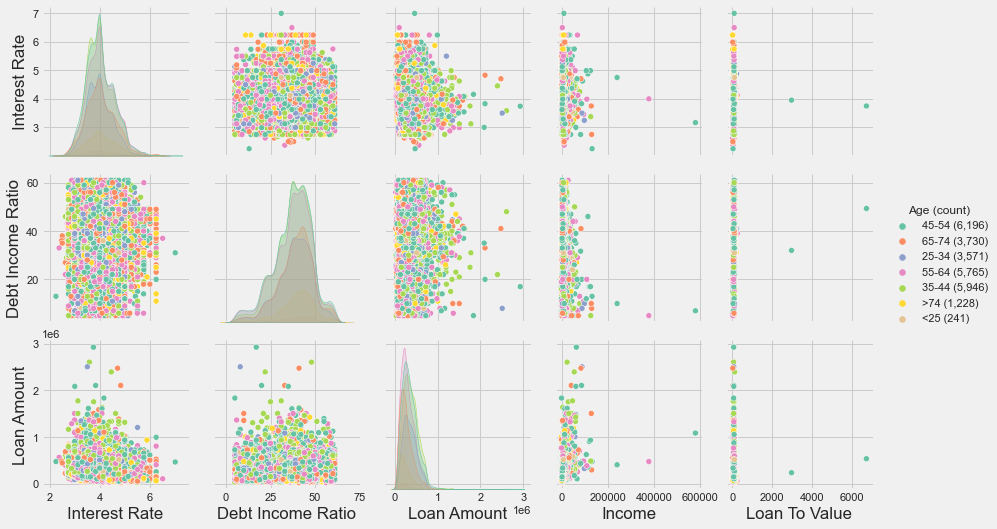

In [70]:
# sns.pairplot(X_test_top8_df, hue="Age (count)", palette='Set2') # use kind='reg' show regression line
sns.pairplot(X_test_top8_df, hue="Age (count)", palette='Set2',
    x_vars=['Interest Rate','Debt Income Ratio','Loan Amount', 'Income', 'Loan To Value'],
    y_vars=['Interest Rate','Debt Income Ratio','Loan Amount'])

### GridSearch

In [71]:

from sklearn.model_selection import GridSearchCV
params = {'max_depth':range(2, 7), 'learning_rate':np.arange(0.1,0.9,0.1)}
model = GridSearchCV(estimator=XGmodel, param_grid=params, cv=5,verbose=4)	 
model.fit(X_train_std, Y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ....learning_rate=0.1, max_depth=2;, score=0.893 total time=   1.9s
[CV 2/5] END ....learning_rate=0.1, max_depth=2;, score=0.895 total time=   1.1s
[CV 3/5] END ....learning_rate=0.1, max_depth=2;, score=0.889 total time=   1.4s
[CV 4/5] END ....learning_rate=0.1, max_depth=2;, score=0.894 total time=   1.3s
[CV 5/5] END ....learning_rate=0.1, max_depth=2;, score=0.897 total time=   1.2s
[CV 1/5] END ....learning_rate=0.1, max_depth=3;, score=0.944 total time=   1.9s
[CV 2/5] END ....learning_rate=0.1, max_depth=3;, score=0.939 total time=   1.7s
[CV 3/5] END ....learning_rate=0.1, max_depth=3;, score=0.934 total time=   1.9s
[CV 4/5] END ....learning_rate=0.1, max_depth=3;, score=0.938 total time=   1.8s
[CV 5/5] END ....learning_rate=0.1, max_depth=3;, score=0.941 total time=   1.7s
[CV 1/5] END ....learning_rate=0.1, max_depth=4;, score=0.958 total time=   2.4s
[CV 2/5] END ....learning_rate=0.1, max_depth=4

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'max_depth': range(2, 7)},
             verbose=4)

In [72]:

print("model's best parameter ：",model.best_params_)
print("model's best score：",model.best_score_)
print("model's best estimator：",model.best_estimator_)

model's best parameter ： {'learning_rate': 0.4, 'max_depth': 6}
model's best score： 0.975275143016936
model's best estimator： XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [73]:
grid_result=pd.DataFrame(model.cv_results_)[['param_learning_rate','param_max_depth','mean_test_score']]
grid_result

,param_learning_rate,param_max_depth,mean_test_score
0,0.1,2,0.893520
1,0.1,3,0.938993
2,0.1,4,0.960386
3,0.1,5,0.968050
4,0.1,6,0.971335
5,0.2,2,0.946779
6,0.2,3,0.964756
7,0.2,4,0.973207
8,0.2,5,0.974367
9,0.2,6,0.975041


In [74]:
heat_df=grid_result.pivot_table(columns='param_learning_rate',index='param_max_depth')
heat_df=heat_df.applymap(lambda x:"%.2f" % x )
heat_data=np.array(heat_df,dtype=np.float64)

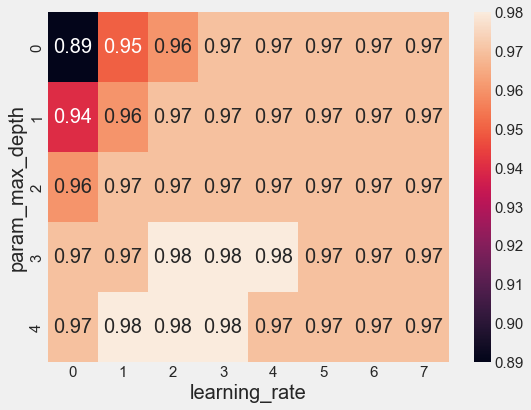

In [78]:

# xticklabels=['Declined', 'Approved'],yticklabels=['Declined', 'Approved']
ax = sns.heatmap(heat_data,annot=True,fmt='g',annot_kws={"fontsize":20})
#xticklabels、yticklabels
ax.set_xlabel('learning_rate',size=20) 
ax.set_ylabel('param_max_depth',size=20) 
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.gcf().set_size_inches(8, 6)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# plt.savefig(filename)
plt.show()

## 4 model evaluation

In [81]:
method_result=pd.DataFrame(method_compare)
method_result.to_csv('./save/method_result.csv',index=False,encoding='utf_8_sig')
method_result

,BaselineName,Accuracy,Precision,MCC,PPV,NPV,Recall,F1,TP,FP,TN,FN
0,ExtraTrees,0.877480,0.843730,0.459019,0.843730,0.879566,0.302165,0.444972,1312,243,22129,3030
1,KNeighbors,0.846186,0.579306,0.272496,0.579306,0.861715,0.195993,0.292893,851,618,21754,3491
2,XGBoost,0.975780,0.984273,0.909103,0.984273,0.974366,0.864809,0.920682,3755,60,22312,587
3,DecisionTree,0.946957,0.825217,0.808099,0.825217,0.971598,0.854675,0.839688,3711,786,21586,631
4,RandomForest,0.928352,0.909030,0.715326,0.909030,0.930767,0.621373,0.738167,2698,270,22102,1644
5,GradientBoosting,0.943999,0.974017,0.782602,0.974017,0.940199,0.673422,0.796296,2924,78,22294,1418


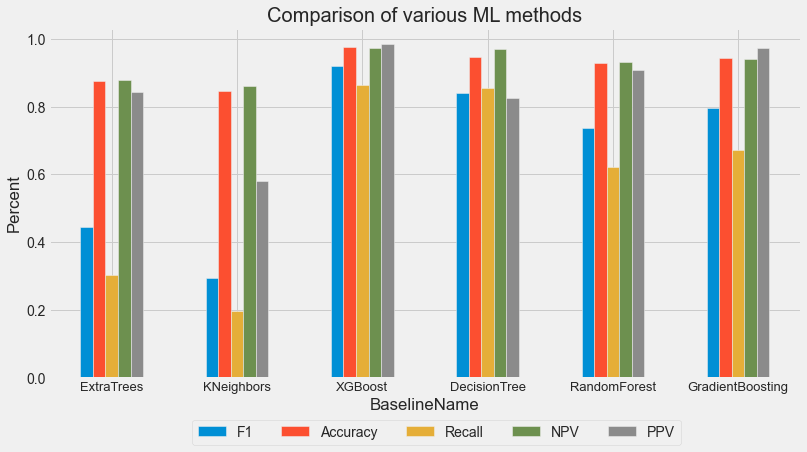

In [82]:
# comparison
method_result.index=method_result.BaselineName
Acc_result=method_result[['F1','Accuracy','Recall','NPV','PPV']]
plt.figure(figsize=(12,6))
Acc_result.plot.bar(rot=0,ax=plt.gca())
plt.ylabel('Percent')
plt.title('Comparison of various ML methods',size=20)
plt.xticks(size=13)
plt.yticks(size=14)
plt.legend(ncol=5,fontsize=14,bbox_to_anchor=(0.85,-0.1))
plt.savefig('save/Comparison of various ML methods.png',bbox_inches = 'tight')
plt.show()

### shap explaination model

In [83]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [84]:
import shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

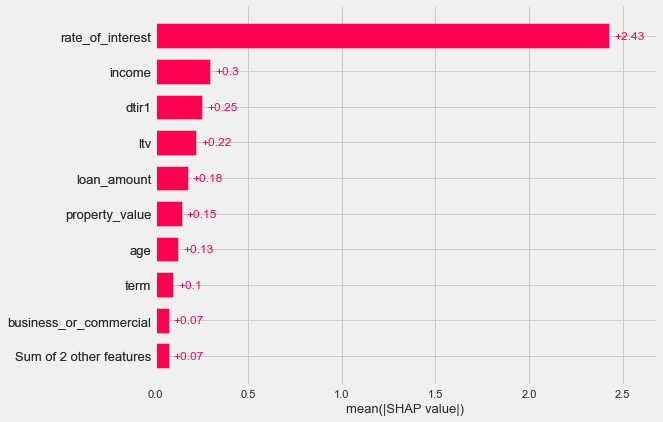

In [85]:
shap.plots.bar(shap_values, max_display=10)

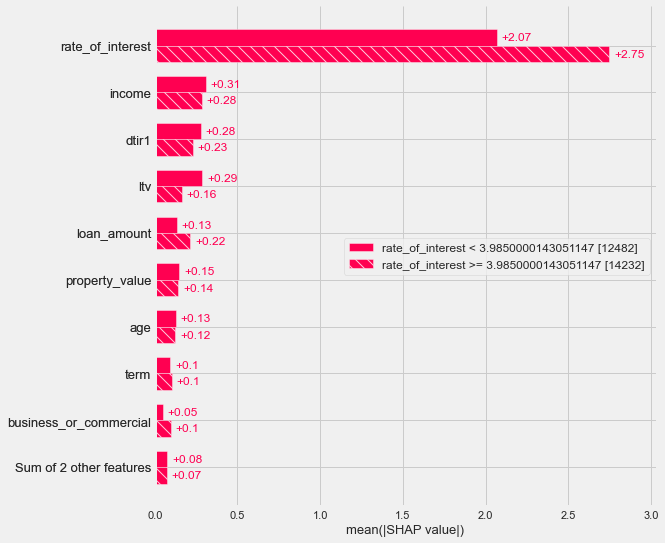

In [86]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

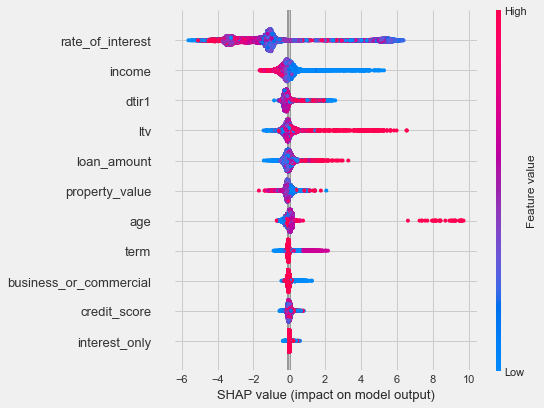

In [87]:
shap.summary_plot(shap_values,X_test,feature_names=X.columns)

In [88]:
methods # 0 2 3 5

['ExtraTrees',
 'KNeighbors',
 'XGBoost',
 'DecisionTree',
 'RandomForest',
 'GradientBoosting']